<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

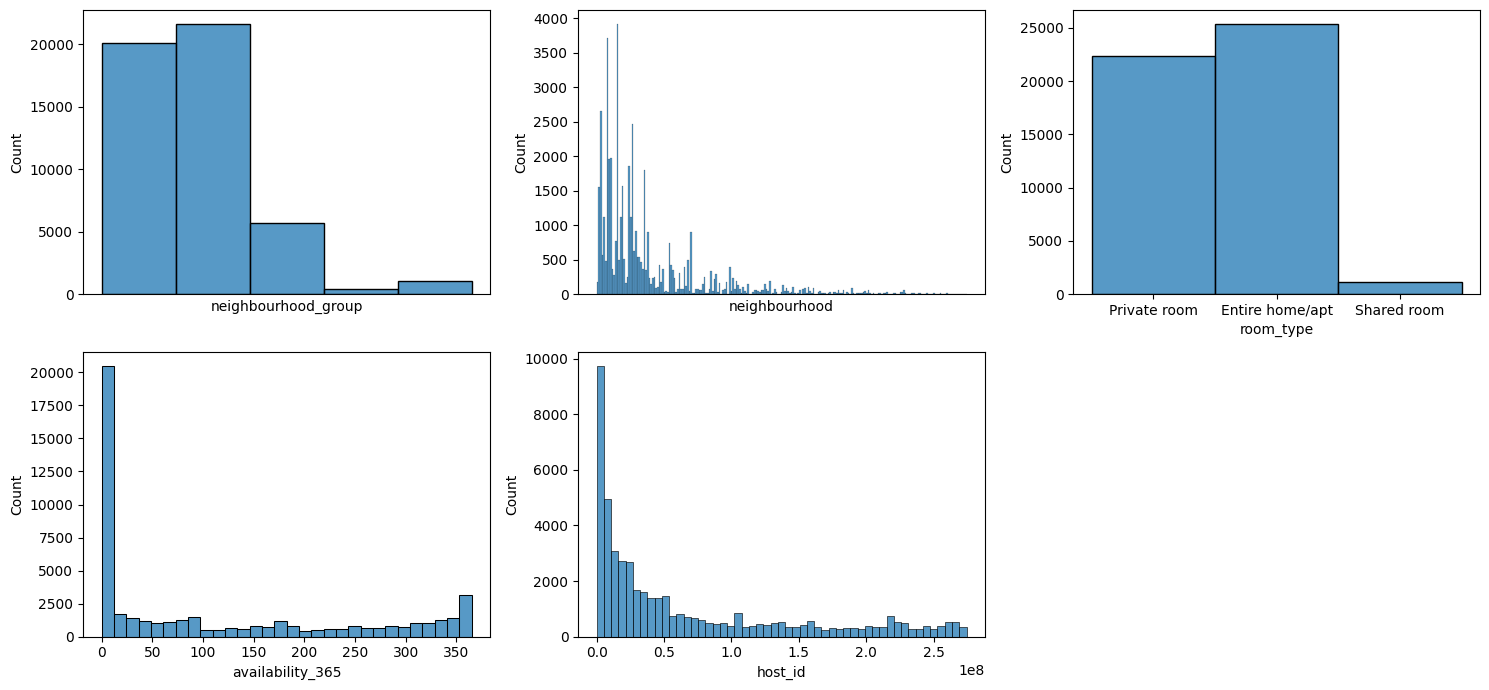

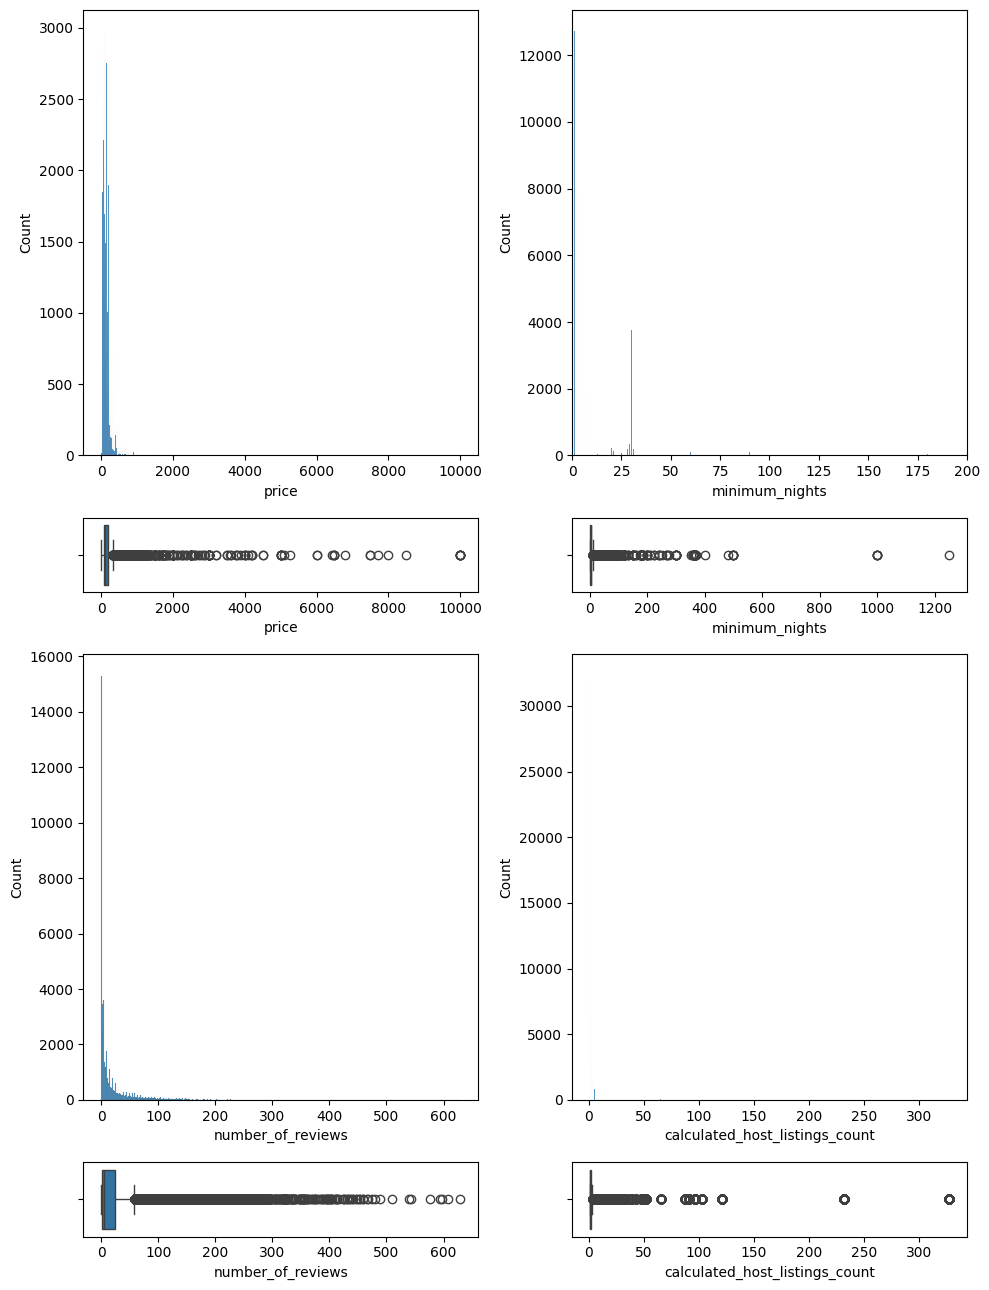

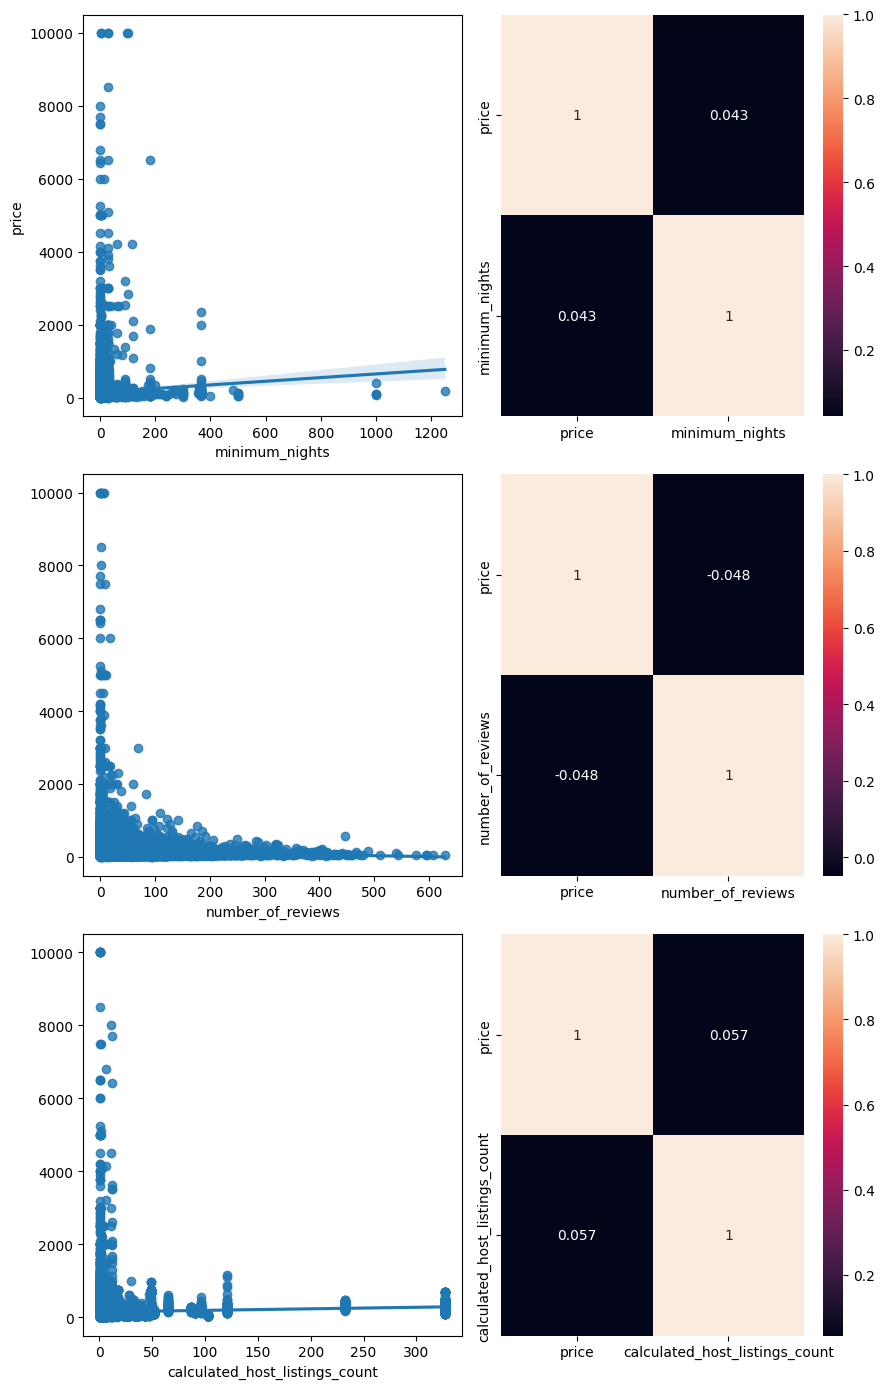

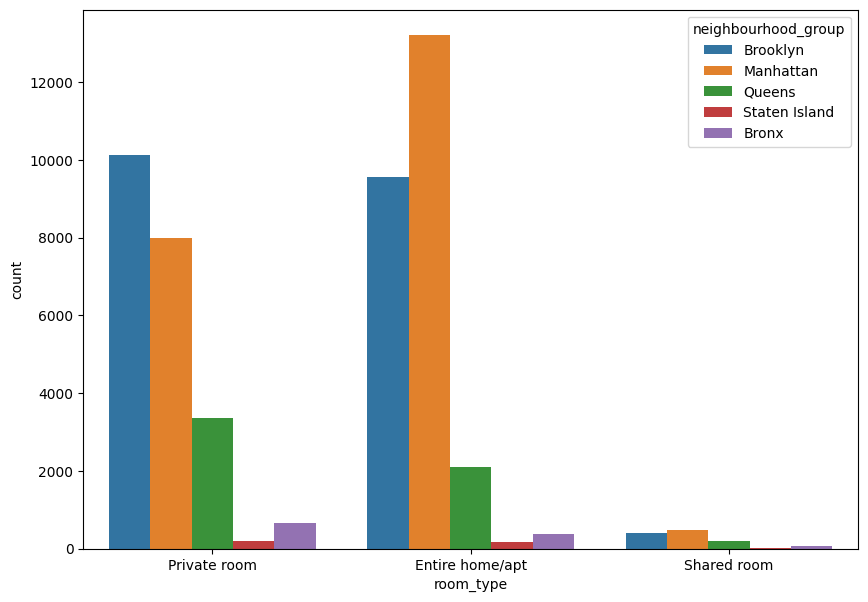

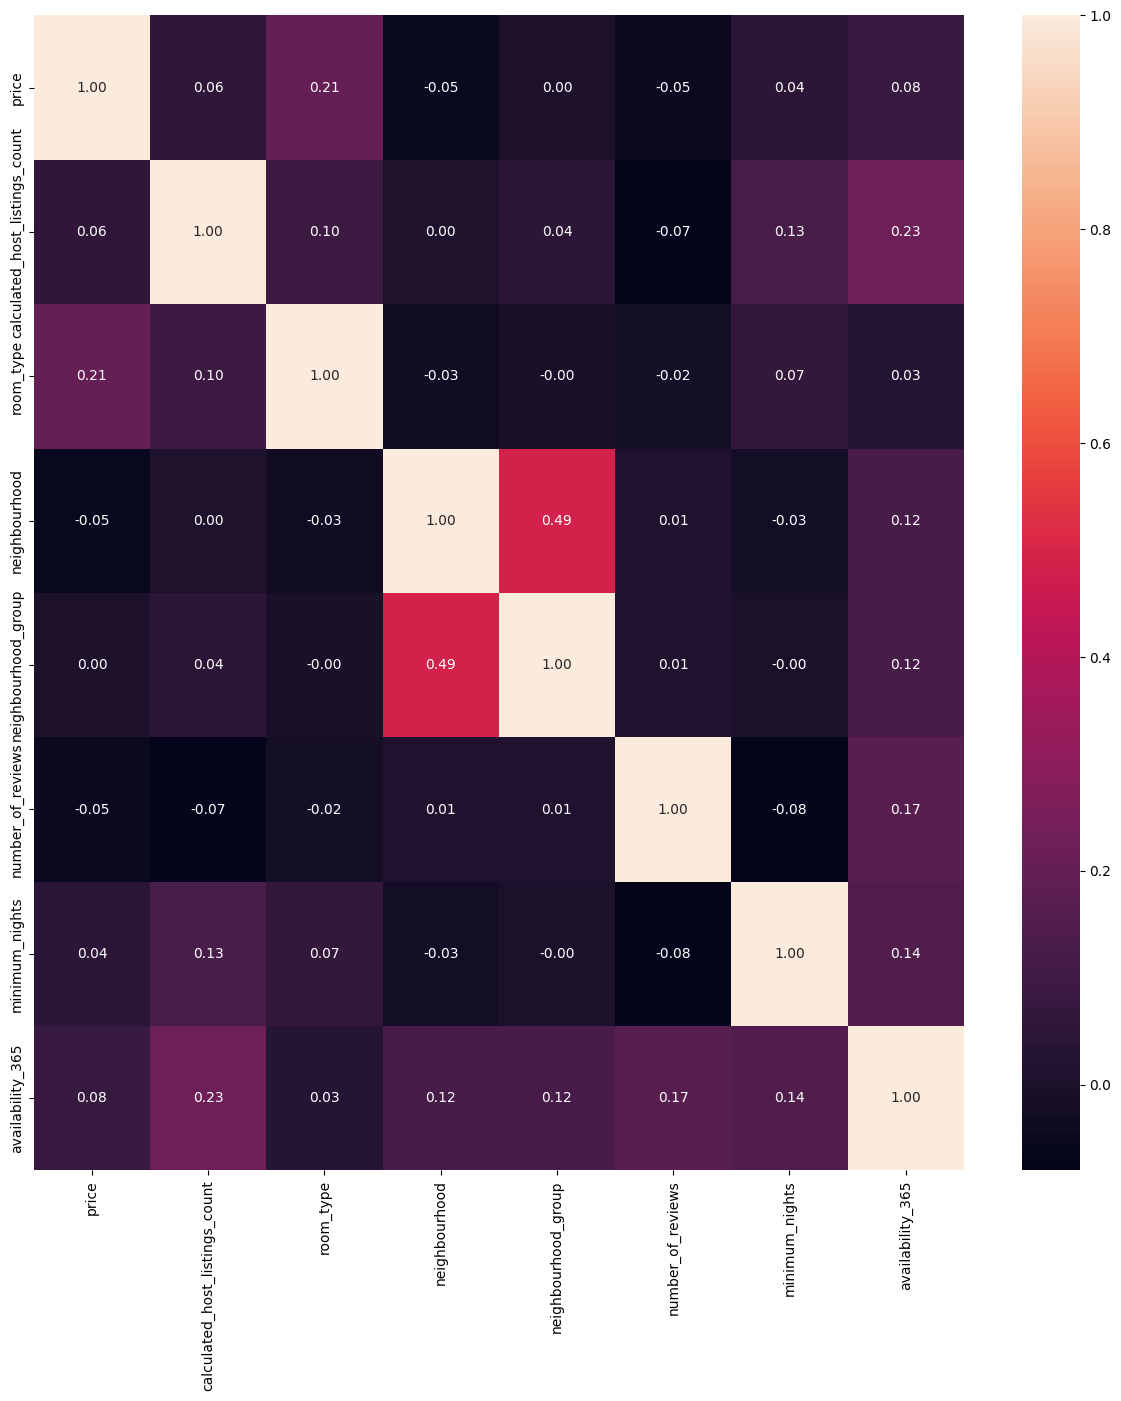

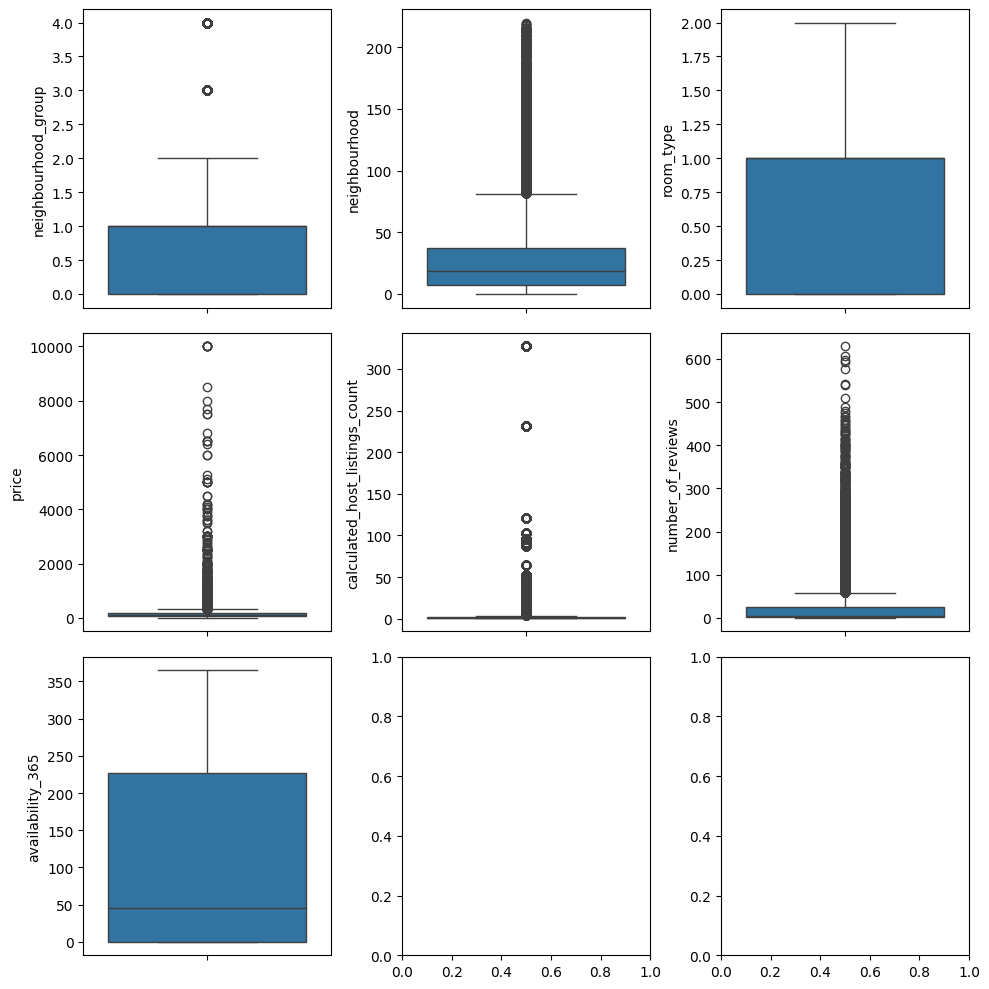

In [1]:
from utils import db_connect
engine = db_connect()

# Your code here
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split

# First we read the CSV
total_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv")

# Then we store the raw data inside the data/raw directory.
total_data.to_csv('/workspaces/ginotomasd-machine-learning-python-template/data/raw/total_data.csv', index=False)

# Now it's time to start processing the data, first, we observe the shape(rows & columns)
total_data.shape
    # The dataframe contains 48895 rows, or values and 16 variables.

# We need to see what type of information is in there
total_data.info()

# Now we can see that there are several variables that have Null values, the biggest ones being 'last_review' and 'reviews_per_month'
# There are 16 variables total, separated into categorial and numerical, 8 for reach category.

# Check for relevant duplicates:
print('The number of duplicate names is:', total_data['name'].duplicated().sum())
print('The number of duplicate host ids is:', total_data['host_id'].duplicated().sum())

# There will be duplicate names because there is a possibility that someone names their AirBnB just like another person
# Same for host ids, the only difference is there can be one person/entity with multiple AirBnBs listed

# Drop all information that's not useful to the analysis:

total_data.drop(['id', 'name', 'host_name', 'reviews_per_month', 'last_review'], axis=1, inplace=True)
total_data.head()

# We have two types of data, categorical and numerical. We are going to analyze them now:

# Categorical data: 'neighbourhood_group', 'neighbourhood', 'room_type', 'availability_365', 'host_id'

fig, axis = plt.subplots(2 , 3, figsize=(15,7))

sns.histplot(ax = axis[0,0], data = total_data, x = "neighbourhood_group").set_xticks([])
sns.histplot(ax = axis[0,1], data = total_data, x = 'neighbourhood').set_xticks([])
sns.histplot(ax = axis[0,2], data = total_data, x = 'room_type')
sns.histplot(ax = axis[1,0], data = total_data, x = 'availability_365')
sns.histplot(ax = axis[1,1], data = total_data, x = 'host_id')
fig.delaxes(axis[1,2])

plt.tight_layout()
plt.show()

# We can observe several patterns inside the data when we visualize it:
    # 1. Neighbourhood Group
        # Most homes belong on the first two groups, while the other 3 groups have the least amount of homes, the fourth being the least populated.
    # 2. Neighbourhood
        # It seems there are certain neighbourhoods that contain a vast percentage of the available ABNBs.
    # 3. Room Type
        # Most of the places in ABNB are either private rooms or entire homes, almost the same amount. On the other hand, shared rooms were not as common for AirBnB in New York City.
    # 4. Availability 365
        # There is a giant spike in the amount of ABNBs without 365 availability, but overall there are still a lot of properties with it.
    # 5 Host ID
        # There are a hosts with more than one ABNB to rent, but there are also a lot of NaN values. 


# Numerical data: 'price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count'

fig, axis = plt.subplots(4, 2, figsize=(10,13), gridspec_kw = {'height_ratios': [6,1,6,1]})

sns.histplot(ax = axis[0,0], data = total_data, x='price')
sns.boxplot(ax = axis[1,0], data = total_data, x='price')

sns.histplot(ax = axis[0,1], data = total_data, x='minimum_nights').set_xlim(0,200)
sns.boxplot(ax = axis[1,1], data = total_data, x='minimum_nights')

sns.histplot(ax = axis[2,0], data = total_data, x='number_of_reviews')
sns.boxplot(ax = axis[3,0], data = total_data, x='number_of_reviews')

sns.histplot(ax = axis[2,1], data = total_data, x='calculated_host_listings_count')
sns.boxplot(ax = axis[3,1], data = total_data, x='calculated_host_listings_count')

plt.tight_layout()
plt.show()

# Analysis of multivariate variables

# Numerical - Numerical Analysis (Correlation):

fig, axis = plt.subplots(3, 2, figsize=(9,14))

sns.regplot(ax = axis[0,0], data = total_data, x='minimum_nights', y='price')
sns.heatmap(total_data[['price', 'minimum_nights']].corr(), annot=True, ax = axis[0,1])

sns.regplot(ax = axis[1,0], data = total_data, x='number_of_reviews', y='price').set(ylabel = None)
sns.heatmap(total_data[['price', 'number_of_reviews']].corr(), annot=True, ax = axis[1,1])

sns.regplot(ax = axis[2,0], data = total_data, x='calculated_host_listings_count', y='price').set(ylabel = None)
sns.heatmap(total_data[['price', 'calculated_host_listings_count']].corr(), annot=True, ax = axis[2,1])
plt.tight_layout()
plt.show()

# Observations:
    # There are no real correlations between the price and the number of reviews, and the same behaviour applies for stays with minimum nights. 


# Categorical -  Categorical Analysis

fig, axis = plt.subplots(figsize=(10,7))

# We will analyze the room types with their locations, but we can't draw any correlations.

sns.countplot(data=total_data, x = 'room_type', hue = 'neighbourhood_group')
plt.show()

# Conclusions
    # Manhattan has the most places for rent. 
    # A lot of shared rooms are available in Manhattan rather than other neighbourhoods.

# NUMERICAL - CATEGORICAL ANALYSIS

# We factorize the data to analyze it
total_data['room_type'] = pd.factorize(total_data['room_type'])[0]
total_data['neighbourhood'] = pd.factorize(total_data['neighbourhood'])[0]
total_data['neighbourhood_group'] = pd.factorize(total_data['neighbourhood_group'])[0]

fig, axes = plt.subplots(figsize=(15,15))

sns.heatmap(total_data[['price', 'calculated_host_listings_count','room_type','neighbourhood','neighbourhood_group','number_of_reviews','minimum_nights','availability_365']].corr(), annot=True, fmt = '.2f')
plt.show()

# OBSERVATIONS
    # There are no strong correlations between any of the variables, but there is a little correlation between the multiple-property owners and the availability of the ABNBs.

# Outlier Analysis
 
fig, axes = plt.subplots(3,3, figsize=(10,10))

sns.boxplot(ax = axes[0,0], data = total_data, y = 'neighbourhood_group')
sns.boxplot(ax = axes[0,1], data = total_data, y = 'neighbourhood')
sns.boxplot(ax = axes[0,2], data = total_data, y = 'room_type')
sns.boxplot(ax = axes[1,0], data = total_data, y = 'price')
sns.boxplot(ax = axes[1,1], data = total_data, y = 'calculated_host_listings_count')
sns.boxplot(ax = axes[1,2], data = total_data, y = 'number_of_reviews')
sns.boxplot(ax = axes[2,0], data = total_data, y = 'availability_365')

plt.tight_layout()
plt.show()

# We will perform an IQR analysis on all variables to detect outliers

# Price IQR

pricestats = total_data['price'].describe()

priceiqr = pricestats['75%'] - pricestats['25%']
upperlimit = pricestats['75%'] + 1.5 * priceiqr
lowerlimit = pricestats['25%'] - 1.5 * priceiqr
total_data = total_data[total_data['price']> 0]

# Minimum nights IQR

mnstats = total_data['minimum_nights'].describe()

mniqr = mnstats['75%'] - mnstats['25%']
upperlimit2 = mnstats['75%'] + 1.5 * mniqr
lowerlimit2 = mnstats['25%'] - 1.5 * mniqr
total_data = total_data[total_data['minimum_nights'] <= 15]

# Calculated Host Listings Count IQR

chlcstats = total_data['calculated_host_listings_count'].describe()

chlciqr = chlcstats['75%'] - chlcstats['25%']
upperlimit3 = chlcstats['75%'] + 1.5 * chlciqr
total_data = total_data[total_data['calculated_host_listings_count']<= 4]

# 5. Feature Scaling

scaler = MinMaxScaler()

features_to_scale = [
    'number_of_reviews',
    'minimum_nights',
    'calculated_host_listings_count',
    'availability_365'
]

index = total_data.index

scaled_values = scaler.fit_transform(total_data[features_to_scale])
scaled_df = pd.DataFrame(scaled_values, columns=features_to_scale, index=index)

# Attach other columns
 
scaled_df['price'] = total_data['price']
scaled_df['room_type'] = total_data['room_type']
scaled_df['neighbourhood'] = total_data['neighbourhood']
scaled_df['neighbourhood_group'] = total_data['neighbourhood_group']

# We transform to CSV after cleaning data

scaled_df.to_csv('/workspaces/ginotomasd-machine-learning-python-template/data/processed/scaled_total_data.csv', index=False)

# Feature selection
X = scaled_df.drop("price", axis=1)
y = scaled_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

selector = SelectKBest(score_func=chi2, k=4)
selector.fit(X_train, y_train)
selected_features = X_train.columns[selector.get_support()]

X_train_sel = pd.DataFrame(selector.transform(X_train), columns=selected_features)
X_test_sel = pd.DataFrame(selector.transform(X_test), columns=selected_features)
X_train_sel["price"] = y_train.reset_index(drop=True)
X_test_sel["price"] = y_test.reset_index(drop=True)

# Save selected feature sets
X_train_sel.to_csv('/workspaces/ginotomasd-machine-learning-python-template/data/processed/clean_train.csv', index=False)
X_test_sel.to_csv('/workspaces/ginotomasd-machine-learning-python-template/data/processed/clean_test.csv', index=False)